In [297]:
import sys

%load_ext autoreload
%autoreload 1
%aimport pygenesig.validation
%aimport pygenesig.gini
%aimport pygenesig.clevergini
%aimport pygenesig.bioqc
%aimport pygenesig.tools
%aimport pygenesig.perfmeasures
%matplotlib inline

from pygenesig.validation import * 
from pygenesig.gini import * 
from pygenesig.bioqc import * 
from pygenesig.tools import * 
from pygenesig.clevergini import * 
import pygenesig.perfmeasures as pm
import numpy as np
import pandas as pd
import sklearn.metrics as skm 
import os.path
import dask
from distributed import Client, progress
import dask.async
import dask.diagnostics

import seaborn as sns
sns.set_style("ticks", {"axes.grid" : True})
from pylab import * 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Crossvalidation of gini-signature on the GTEx dataset
In this document, we perform a 10-fold cross-validation of signature generation with gini-index. 

## Use dask for parallel computation

In [37]:
c = Client("10.114.185.14:8786")

In [298]:
expr_file = "../results/exprs_by_gene.npy"
target_file = "../results/target.csv"
fdata_file = "../results/fdata_by_gene.tsv"
splitter = sklearn.model_selection.StratifiedKFold(n_splits=10)
signature_generator = CleverGiniSignatureGenerator
signature_tester = BioQCSignatureTester
sg_kwargs = {"min_gini": .6, "max_rk": 3, "min_expr": 3}

In [299]:
exprs = np.load(expr_file)
target = np.genfromtxt(target_file, dtype=str, delimiter=",")
fdata = pd.read_csv(fdata_file, sep="\t", header=None, index_col=0)

In [300]:
sig_list, res_list, train_list, test_list = cv_score(expr_file,
                                                    target_file,
                                                    signature_generator,
                                                    signature_tester,
                                                    splitter,
                                                    sg_kwargs=sg_kwargs)

This is the dask compute graph executed internally: 

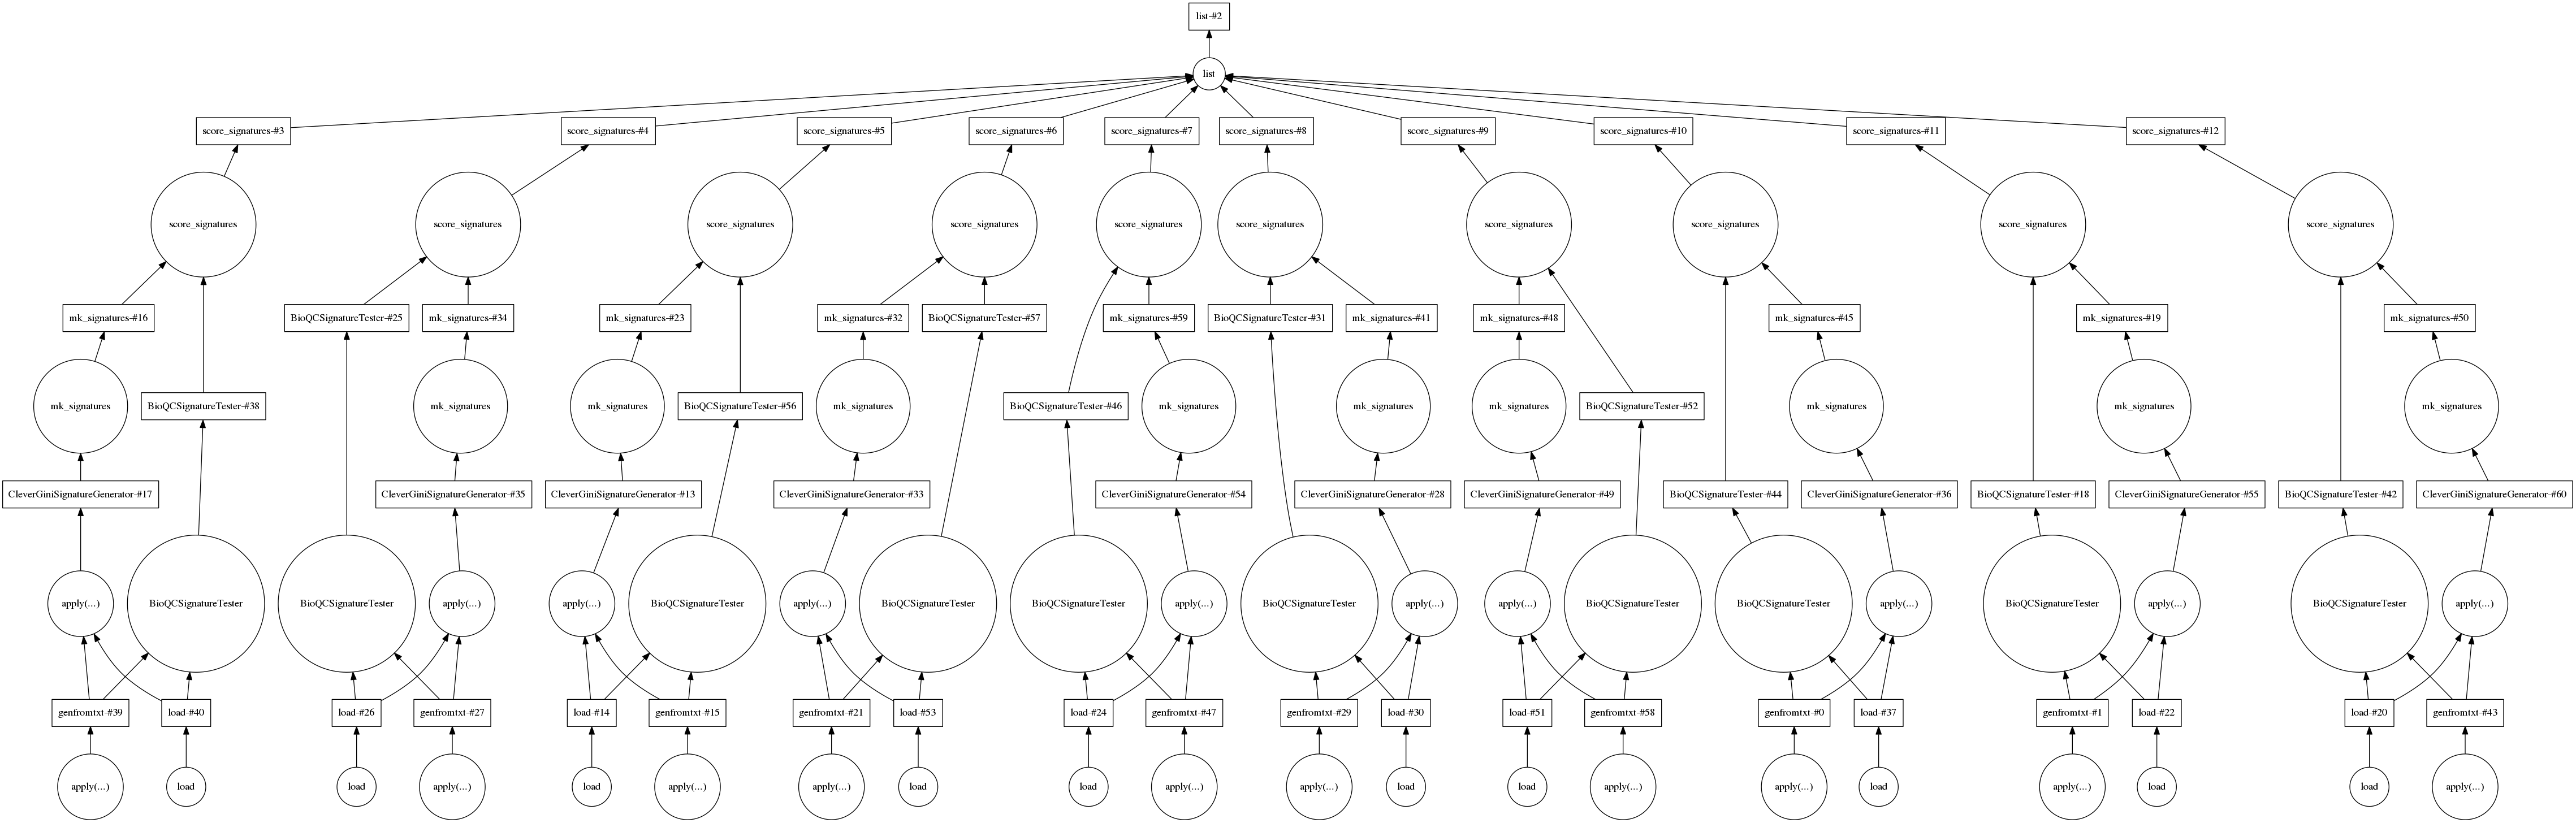

In [301]:
res_list.visualize()

Do the actual computation:

In [302]:
sig_f, res_f = c.compute([sig_list, res_list], sync=False)

In [303]:
progress([sig_f, res_f])

In [243]:
signatures = sig_f.result()

In [244]:
scores = res_f.result()

In [245]:
heatmaps = []
for i, test in enumerate(test_list):
    sig_labels = signature_tester.sort_signatures(signatures[i])
    scores_df = pd.DataFrame(np.transpose(scores[i]))
    scores_df.columns = sig_labels
    scores_df = scores_df.assign(tissue=pd.Series(target[test]))
    scores_per_sig = scores_df.groupby('tissue').mean().transpose()
    heatmaps.append(scores_per_sig)

In [246]:
heatmap_avg = np.mean([hm.as_matrix() for hm in heatmaps], axis=0)

In [247]:
heatmap_df = pd.DataFrame(heatmap_avg)
heatmap_df.index = heatmaps[0].index
heatmap_df.columns = heatmaps[0].columns

In [250]:
sns.set(font_scale=1.5)

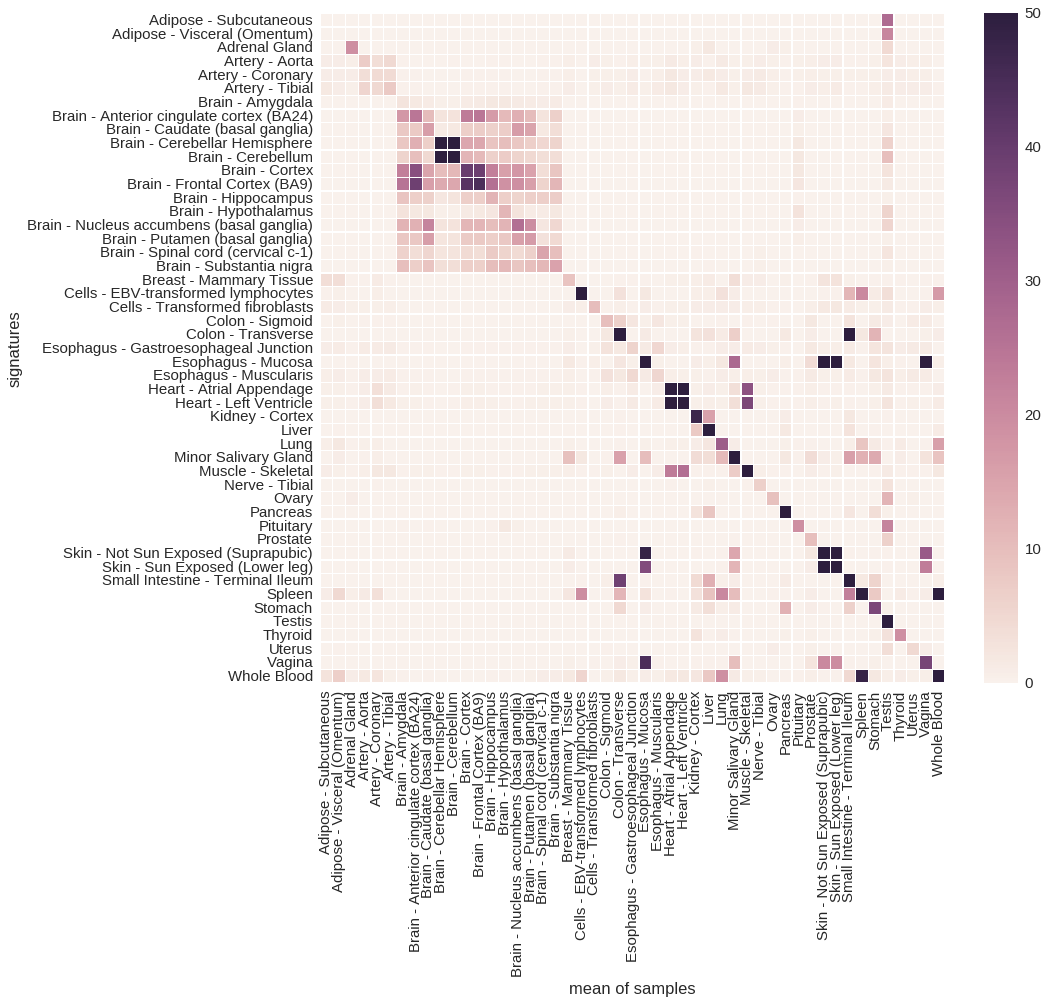

In [251]:
fig, ax = subplots(figsize=(14, 12))
sns.heatmap(heatmap_df, ax=ax, annot=False, annot_kws={"size": 9}, vmin=0, vmax=50, linewidths=.2);
ax.set_ylabel("signatures")
ax.set_xlabel("mean of samples")

## Signature overlap between the folds
The box-plot shows the overlap of the signatures between the different folds. A high jaccard index indicates stability of the signatures between the folds. 

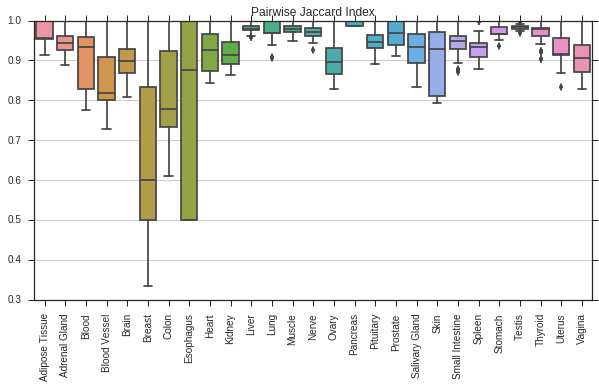

In [199]:
pairwise_jaccard = pairwise_jaccard_ind(signatures)
fig, ax = subplots(figsize=(10,5))
data=pd.DataFrame(pairwise_jaccard)
sns.boxplot(data=data, ax=ax)
ax.set_title("Pairwise Jaccard Index")
ax.set_xticklabels(data.columns, rotation=90);

## Export signatures

In [155]:
exprs.shape

(31819, 8525)

In [257]:
aggr_df = aggregate_expression(exprs, target)

In [265]:
s = aggr_df.iloc[1,:].sort(inplace=False, ascending =False)

/pstore/apps/Anaconda3/2.5.0/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting
  if __name__ == '__main__':


In [268]:
s.drop(s.index[0])

Spleen                                       6.710870
Brain - Cerebellum                           6.264955
Brain - Cortex                               6.252591
Brain - Cerebellar Hemisphere                6.182049
Cells - Transformed fibroblasts              5.717126
Brain - Frontal Cortex (BA9)                 5.488692
Cells - EBV-transformed lymphocytes          5.449914
Uterus                                       4.985851
Artery - Coronary                            4.706785
Thyroid                                      4.656777
Brain - Anterior cingulate cortex (BA24)     4.466397
Brain - Nucleus accumbens (basal ganglia)    4.439606
Brain - Hypothalamus                         3.937817
Lung                                         3.921170
Brain - Caudate (basal ganglia)              3.817472
Nerve - Tibial                               3.798254
Breast - Mammary Tissue                      3.635525
Prostate                                     3.509637
Vagina                      

In [320]:
def mk_and_evaluate_signatures(expr, target):
    sg = GiniSignatureGenerator(expr, target, aggregate_fun=np.median, min_expr=5, min_gini=.8, max_rk=3)
    st = BioQCSignatureTester(expr, target)
    signatures = sg.mk_signatures()
    rogini = "" # sg.get_rogini_format()
    scores = st.score_signatures(signatures)
    return signatures, rogini, scores

In [321]:
rosetta = dict(zip(fdata.index, fdata.iloc[:,0]))

In [322]:
signatures, rogini, scores = mk_and_evaluate_signatures(exprs, target)

/pstore/home/sturmg/projects/pygenesig/pygenesig/bioqc.py:157: RuntimeWarning: divide by zero encountered in log10
  bioqc_res_log = -np.log10(bioqc_res)


In [323]:
scores_df = pd.DataFrame(np.transpose(scores))
scores_df.columns = signature_tester.sort_signatures(signatures)
scores_df['tissue'] = pd.Series(target)
scores_per_sig = scores_df.groupby('tissue').median().transpose()

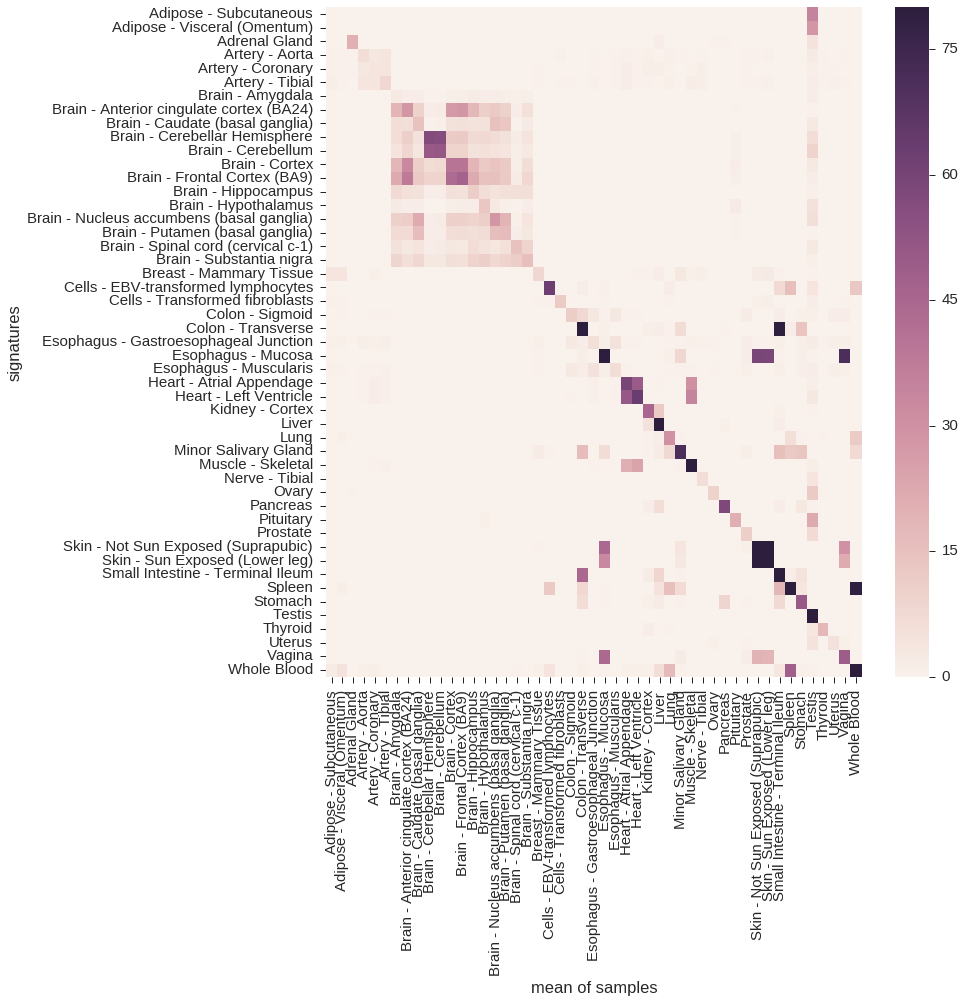

In [326]:
fig, ax = subplots(figsize=(12,12))
sns.heatmap(scores_per_sig, ax=ax, annot=False, annot_kws={"size": 9}, vmin=0, vmax=80);
ax.set_ylabel("signatures")
ax.set_xlabel("mean of samples")

In [343]:
jac_mat = jaccard_mat(signatures, signatures, as_matrix=True)

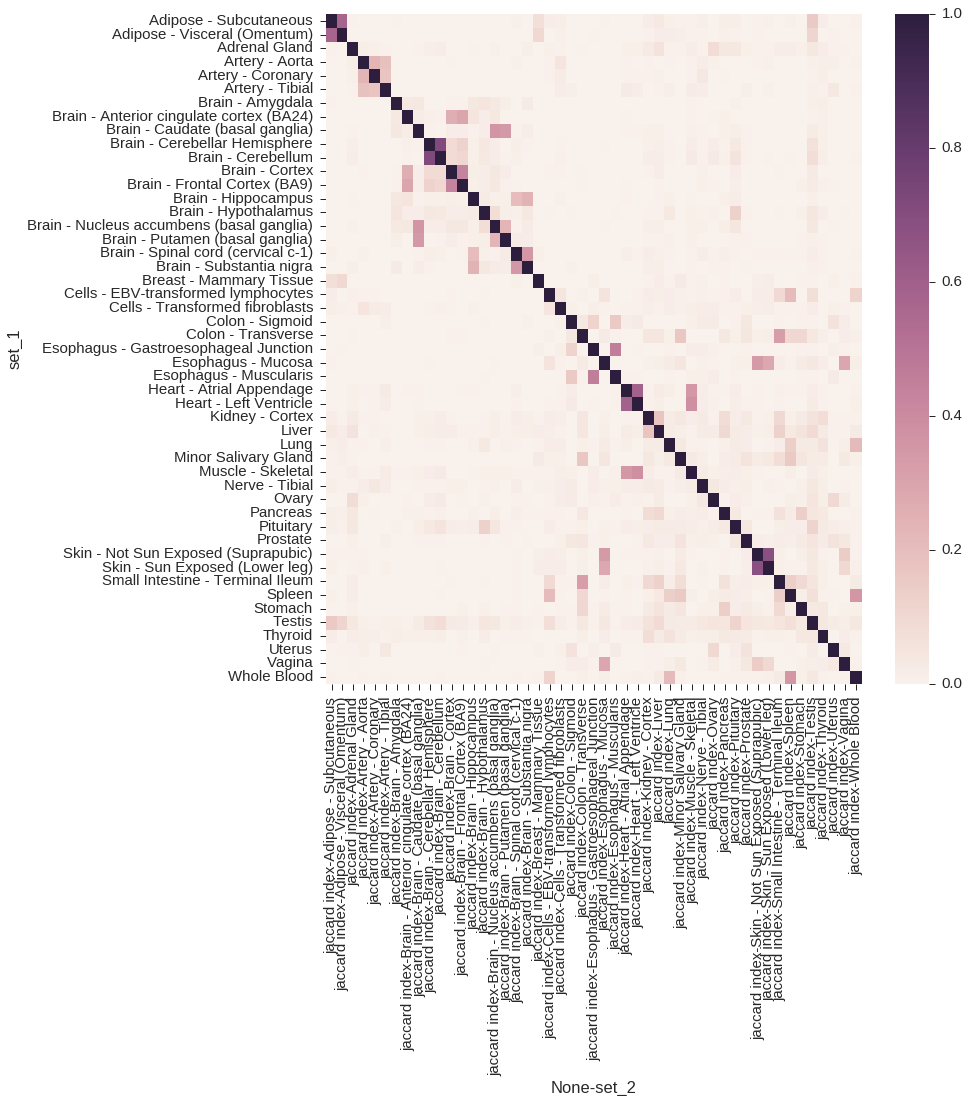

In [346]:
fig, ax = subplots(figsize=(12,12))
sns.heatmap(jac_mat, ax=ax)

In [317]:
signatures_hgnc = translate_signatures(signatures, rosetta)

In [318]:
write_gmt(signatures_hgnc, "../results/gtex_clevergini.gmt")

In [319]:
len(signatures_hgnc["Adipose Tissue"])

KeyError: 'Adipose Tissue'

In [140]:
print("\n".join(signatures_hgnc["Adipose Tissue"]))

MAGEB1
PON1
KCNK2
KCNK3
RN7SL186P
RP11-118H17
RP11-118N24
C12orf50
DBH
KCNN2
AADAC
KCNQ1
RP11-983C2
RP11-535C7
TPD52L3
RP11-536N17
DCAF4L2
FAM92A1P2
ABCB1
MPC1L
ABCB4
SORCS3-AS1
RSU1P2
AC091633
KDM4D
RP11-124K4
MAP3K15
C16orf95
C16orf97
MRAP
C17orf112
RP11-547C13
RP11-340A13
RP11-548K12
C17orf98
SPANXC
SPANXD
PPM1E
SPANXN3
SPANXN4
SPANXN5
KIAA1210
SPATA12
C19orf45
RP11-552I14
DDX53
RP13-60M5
SPATA31D1
FBXW10
AC002115
C1QB
SPATA31D5P
RP13-653N12
C1QTNF1-AS1
RP11-1338A24
SPATA8
PPP1R2P2
RP13-81N3
SPATA8-AS1
KIF17
SPATS1
PPP1R2P9
RP11-556N21
RP11-347E10
RN7SL386P
AMDHD1
ZCCHC13
KIF2B
FCN2
AMHR2
RP11-349E4
DEFB123
SPESP1
C1orf185
RP11-34D15
FDXR
COX7B2
MC2R
MCCD1
CPB1
MCF2
AC093822
MCF2L2
C1orf65
MCHR2-AS1
PRAME
RP11-566J3
SCARB1
RP11-566K19
SPO11
CPN2
C20orf173
FGF12
MS4A5
KLHDC8A
AC096655
C21orf54
RP3-430A16
KLHL4
FGG
SPZ1
CREB3L3
C2orf53
RP3-446N13
FIBCD1
RP3-453P22
SCP2D1
DIAPH3-AS2
RP11-147C23
RP3-461P17
RP3-462C17
RP3-467K16
C3orf30
KNDC1
PRKACG
MEG8
MEG9
MT3
ANKRD7
C3orf84
RP11-14D2